In [10]:
import numpy as np
import pandas as pd
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tests_and_graphing import *

In [11]:
def draw_graph(A:np.ndarray, group_labels=None):
    n = A.shape[0]
    G = nx.from_numpy_array(A, create_using=nx.Graph)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(6, 6))
    if group_labels is None:
        nx.draw(G, pos=pos, with_labels=False, node_color="lightblue", edge_color="black")
    else:
        unique_groups = list(set(group_labels))
        colors = plt.cm.get_cmap("tab10", len(unique_groups))
        color_map = {group: colors(i) for i, group in enumerate(unique_groups)}
        node_colors = [color_map[group_labels[node]] for node in G.nodes]
        print(node_colors)
        nx.draw(G, pos=pos, with_labels=False, node_color=node_colors, edge_color="black")

# graph structure

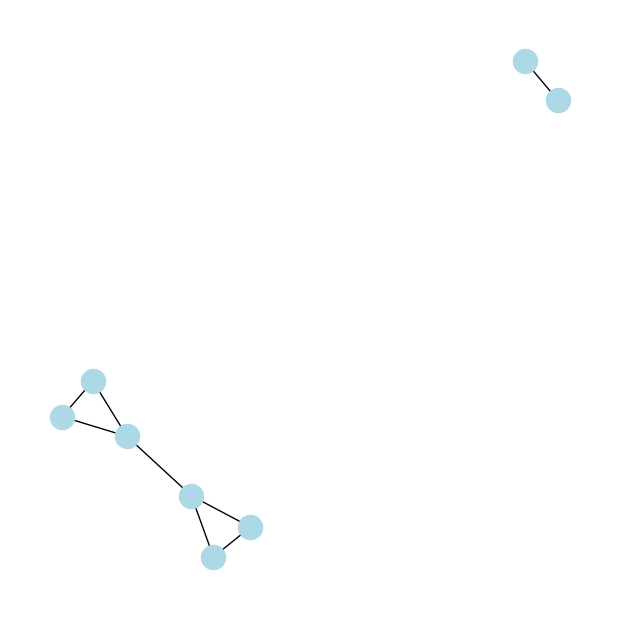

In [ ]:
k = 2

AL = {
    0: [1,2,3,6],
    1: [0,2],
    2: [0,1],
    3: [4,5,0,6],
    4: [3,5],
    5: [3,4],
    6: [7,8,0,3],
    7: [6,8],
    8: [6,7]
}

# Get the adjacency matrix as a NumPy array
G = nx.from_dict_of_lists(AL)
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=0)) #find the degree of each node
m, n = A.shape
draw_graph(A)

# Doing an SVD decomposition on the |L|= D + A

In [13]:
L_ABS = D + A
U, S, V = np.linalg.svd(L_ABS)
S = np.diag(S)
U_k = U[:,0:k]
S_k = S[0:k,0:k]
V_k = V[:k,:]

print(np.round(U_k @ S_k @ V_k))
print(np.round(U_k, decimals = 3))
print(np.round(V_k, decimals=3))
print(np.round(V, decimals = 3))

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  1.  1.  1.  0.  0.]
 [ 0.  0.  1.  1.  1.  0. -0. -0.]
 [ 0.  0.  1.  1.  1.  0. -0. -0.]
 [ 0.  0.  1.  0.  0.  2.  1.  1.]
 [ 0.  0.  0. -0. -0.  2.  1.  1.]
 [ 0.  0.  0. -0. -0.  2.  1.  1.]]
[[ 0.     0.   ]
 [ 0.     0.   ]
 [-0.577  0.408]
 [-0.289  0.408]
 [-0.289  0.408]
 [-0.577 -0.408]
 [-0.289 -0.408]
 [-0.289 -0.408]]
[[-0.    -0.    -0.577 -0.289 -0.289 -0.577 -0.289 -0.289]
 [ 0.     0.     0.408  0.408  0.408 -0.408 -0.408 -0.408]]
[[-0.    -0.    -0.577 -0.289 -0.289 -0.577 -0.289 -0.289]
 [ 0.     0.     0.408  0.408  0.408 -0.408 -0.408 -0.408]
 [-0.    -0.     0.408 -0.408 -0.408  0.408 -0.408 -0.408]
 [-0.707 -0.707 -0.    -0.    -0.     0.     0.     0.   ]
 [-0.    -0.     0.577 -0.289 -0.289 -0.577  0.289  0.289]
 [ 0.     0.     0.     0.7   -0.7    0.    -0.1    0.1  ]
 [ 0.     0.     0.    -0.1    0.1   -0.    -0.7    0.7  ]
 [-0.707  0.707  0.     0.     0.     0.     0.   

In [14]:
print(L_ABS)

[[1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 1. 1. 1. 0. 0.]
 [0. 0. 1. 2. 1. 0. 0. 0.]
 [0. 0. 1. 1. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0. 3. 1. 1.]
 [0. 0. 0. 0. 0. 1. 2. 1.]
 [0. 0. 0. 0. 0. 1. 1. 2.]]


# Compute cosine matrix

In [15]:
CM = cosine_similarity(L_ABS, k)
print(np.round(CM, decimals = 3))


[[ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.5    0.333  0.333  0.167  0.     0.   ]
 [ 0.     0.     0.333  0.25   0.25  -0.    -0.083 -0.083]
 [ 0.     0.     0.333  0.25   0.25  -0.    -0.083 -0.083]
 [ 0.     0.     0.167 -0.    -0.     0.5    0.333  0.333]
 [ 0.     0.    -0.    -0.083 -0.083  0.333  0.25   0.25 ]
 [ 0.     0.    -0.    -0.083 -0.083  0.333  0.25   0.25 ]]


# Reorder cosine matrix

In [16]:
INDEX = [] # global reordering index
CM_COPY = CM.copy()
indices = list(range(0,CM.shape[1]))
while(len(indices) > 1):
    # sort by cosine similarity
    similarity_list = CM_COPY[0,:]
    new_indices = np.argsort(similarity_list)[::-1]
    
    # rearrange matrix
    indices = [indices[i] for i in new_indices]
    CM_COPY = CM_COPY[np.ix_(new_indices,new_indices)]

    # remove and update
    INDEX.append(indices[0])
    indices.pop(0)
    CM_COPY = CM_COPY[1:,1:]
INDEX.append(indices[0])
del CM_COPY
print(INDEX)
CM_REORDERED = CM[np.ix_(INDEX, INDEX)]
CM_REORDERED

# this only mismatches the paper's example because vertex 2 is exactly similar to vertex 0 so their ordering doesnt matter

[7, 5, 6, 3, 2, 4, 0, 1]


array([[ 2.50000000e-01,  3.33333333e-01,  2.50000000e-01,
        -8.33333333e-02, -5.55111512e-17, -8.33333333e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 3.33333333e-01,  5.00000000e-01,  3.33333333e-01,
        -1.38777878e-16,  1.66666667e-01, -5.55111512e-17,
         0.00000000e+00,  0.00000000e+00],
       [ 2.50000000e-01,  3.33333333e-01,  2.50000000e-01,
        -8.33333333e-02, -5.55111512e-17, -8.33333333e-02,
         0.00000000e+00,  0.00000000e+00],
       [-8.33333333e-02, -5.55111512e-17, -8.33333333e-02,
         2.50000000e-01,  3.33333333e-01,  2.50000000e-01,
         0.00000000e+00,  0.00000000e+00],
       [ 5.55111512e-17,  1.66666667e-01,  5.55111512e-17,
         3.33333333e-01,  5.00000000e-01,  3.33333333e-01,
         0.00000000e+00,  0.00000000e+00],
       [-8.33333333e-02, -1.38777878e-16, -8.33333333e-02,
         2.50000000e-01,  3.33333333e-01,  2.50000000e-01,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.000000

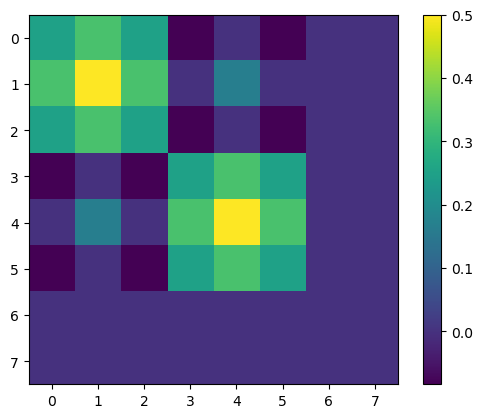

In [17]:
import matplotlib.pyplot as plt

plt.imshow(CM_REORDERED, cmap='viridis')
plt.colorbar()
plt.show()

In [18]:
print(community_detection(CM_REORDERED, .9))

print(community_strengths(CM_REORDERED, .9, order = 'fro'))

print(community_strengths(CM_REORDERED, .9, order = 2))

[slice(0, 1, None), slice(1, 2, None), slice(2, 3, None), slice(3, 4, None), slice(4, 5, None), slice(5, 6, None), slice(6, 7, None), slice(7, 8, None)]
[np.float64(0.2499999999999999), np.float64(0.4999999999999999), np.float64(0.2499999999999999), np.float64(0.24999999999999978), np.float64(0.4999999999999998), np.float64(0.25), np.float64(0.0), np.float64(0.0)]
[np.float64(0.2499999999999999), np.float64(0.4999999999999999), np.float64(0.2499999999999999), np.float64(0.24999999999999978), np.float64(0.4999999999999998), np.float64(0.25), np.float64(0.0), np.float64(0.0)]
